In [14]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['text.usetex'] = True
import scienceplots
plt.style.use(['science', 'ieee'])
import itertools
import seaborn as sns
import re
import numpy as np

In [15]:
# Set up Seaborn theme
sns.set_theme(style="whitegrid")
colors = itertools.cycle(sns.color_palette("bright"))  # Seaborn 'bright' color palette

In [ ]:
def plot_tensorboard_logs(log_dir):
    # Create subplots for 'ep_len_mean' and 'ep_rew_mean'
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Walk through the log directory to get all event files
    for root, _, files in os.walk(log_dir):
        for file in files:
            if "tfevents" in file:
                file_path = os.path.join(root, file)
                folder_name = os.path.basename(root)  # Get the folder name
                
                # Use regular expression to find the value after 'ps_' up to the next '_'
                match = re.search(r'ps_([\d\.]+)', folder_name)
                if match:
                    folder_name = match.group(1)  # Extract the value after 'ps_'
                
                file_color = next(colors)  # Assign a unique color to this file
                
                # Initialize data for the current file
                scalar_data = {'rollout/ep_len_mean': {'steps': [], 'values': [], 'errors': []},
                               'rollout/ep_rew_mean': {'steps': [], 'values': [], 'errors': []}}

                # Read the event file
                for event in tf.compat.v1.train.summary_iterator(file_path):
                    for value in event.summary.value:
                        # Only store data for 'rollout/ep_len_mean' and 'rollout/ep_rew_mean'
                        if value.tag in scalar_data:
                            scalar_data[value.tag]['steps'].append(event.step)
                            scalar_data[value.tag]['values'].append(value.simple_value)

                # Calculate the error (standard deviation) for each step, if there are multiple entries for the same step
                for tag in scalar_data:
                    steps = list(set(scalar_data[tag]['steps']))
                    errors = []
                    for step in steps:
                        values_at_step = [v for s, v in zip(scalar_data[tag]['steps'], scalar_data[tag]['values']) if s == step]
                        if len(values_at_step) > 1:
                            error = np.std(values_at_step)  # Standard deviation as the error
                        else:
                            error = 0  # No error if only one value exists at the step
                        errors.append(error)
                    scalar_data[tag]['errors'] = errors

                # Plot 'ep_len_mean' if data was found
                if scalar_data['rollout/ep_len_mean']['steps']:
                    sns.lineplot(x=scalar_data['rollout/ep_len_mean']['steps'],
                                 y=scalar_data['rollout/ep_len_mean']['values'],
                                 ax=axes[0], color=file_color, label=fr'$\alpha = {folder_name}$', errorbar=None)
                    axes[0].fill_between(scalar_data['rollout/ep_len_mean']['steps'],
                                         np.array(scalar_data['rollout/ep_len_mean']['values']) - np.array(scalar_data['rollout/ep_len_mean']['errors']),
                                         np.array(scalar_data['rollout/ep_len_mean']['values']) + np.array(scalar_data['rollout/ep_len_mean']['errors']),
                                         color=file_color, alpha=0.3)  # Add error shading
                    axes[0].set_xlabel(r"Time Step")
                    axes[0].set_ylabel(r"Episode Length Mean")

                # Plot 'ep_rew_mean' if data was found
                if scalar_data['rollout/ep_rew_mean']['steps']:
                    sns.lineplot(x=scalar_data['rollout/ep_rew_mean']['steps'],
                                 y=scalar_data['rollout/ep_rew_mean']['values'],
                                 ax=axes[1], color=file_color, label=fr'$\alpha = {folder_name}$', errorbar=None)
                    axes[1].fill_between(scalar_data['rollout/ep_rew_mean']['steps'],
                                         np.array(scalar_data['rollout/ep_rew_mean']['values']) - np.array(scalar_data['rollout/ep_rew_mean']['errors']),
                                         np.array(scalar_data['rollout/ep_rew_mean']['values']) + np.array(scalar_data['rollout/ep_rew_mean']['errors']),
                                         color=file_color, alpha=0.3)  # Add error shading
                    axes[1].set_xlabel(r"Time Step")
                    axes[1].set_ylabel(r"Episode Reward Mean")

    # Add legends to each subplot
    axes[0].legend(loc='upper left', frameon=True, framealpha=1)
    axes[1].legend(loc='lower right', frameon=True, framealpha=1)
 

    # Save the plot as a .pdf file in the same folder
    save_path = os.path.dirname(log_dir)  # Use the same folder as the event file
    pdf_filename = os.path.join(save_path, 'tensorboard_plot.pdf')
    plt.tight_layout()
    plt.savefig(pdf_filename, format='pdf')
    plt.show()

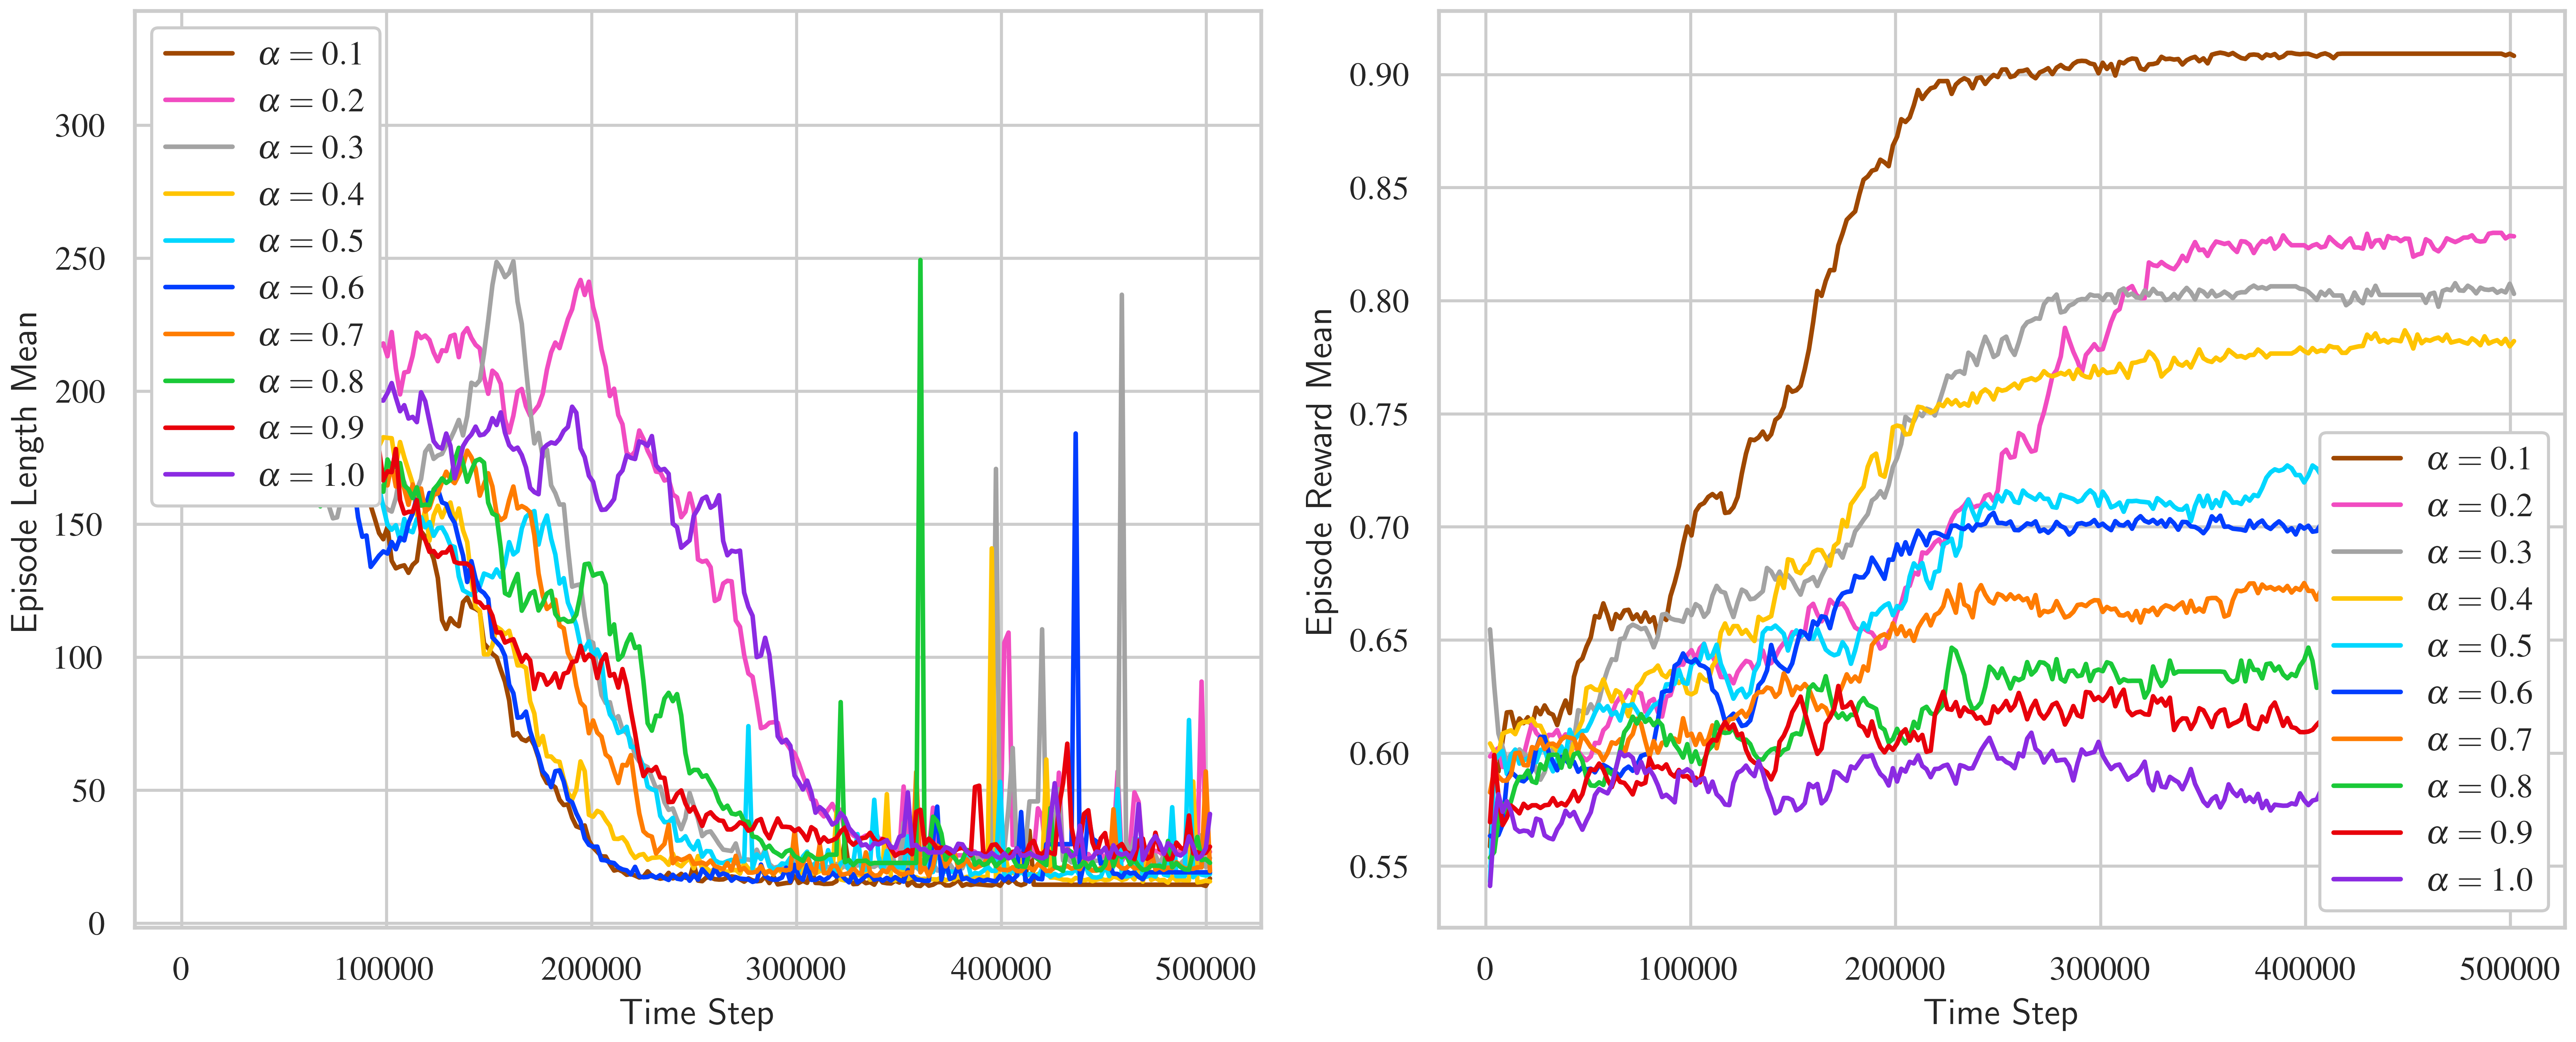

In [76]:
# Specify the log directory containing TensorBoard logs
log_dir = "./tensorboard_alpha/15x15/"
plot_tensorboard_logs(log_dir)